In [1]:
# Imports
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Import utilities
import os
print(os.listdir("../input"))
import time
import ast
import math

# Import visualization
import matplotlib.pyplot as plt

# Import torch
import torch
import torch.nn as nn
import torch.nn.functional as f

['sample_submission.csv', 'test_simplified.csv', 'test_raw.csv', 'train_simplified']


## Load data

In [2]:
# define 10 classes to load the data for
categories = ['cannon','eye', 'face', 'nail', 'pear','piano','radio','spider','star','sword']
label_dict = {0:'cannon',1:'eye', 2:'face', 3:'nail', 4:'pear',
                      5:'piano',6:'radio', 7:'spider', 8:'star', 9:'sword'}

# load data for each category
classes = {}
for category in categories:
    data = pd.read_csv("../input/train_simplified/" + category + ".csv")
    classes[category] = data

## Preprocess data

In [3]:
category = 'pear'

data = classes[category]
values = [ast.literal_eval(img) for img in data['drawing'].values]

In [4]:
# Source:
# https://www.tensorflow.org/tutorials/sequences/recurrent_quickdraw

def parse_line(inkarray):
    """Parse an ndjson line and return ink (as np array) and classname."""
    stroke_lengths = [len(stroke[0]) for stroke in inkarray]
    total_points = sum(stroke_lengths)
    np_ink = np.zeros((total_points, 3), dtype=np.float32)
    current_t = 0
    for stroke in inkarray:
        for i in [0, 1]:
            np_ink[current_t:(current_t + len(stroke[0])), i] = stroke[i]
        current_t += len(stroke[0])
        np_ink[current_t - 1, 2] = 1  # stroke_end
    # Preprocessing.
    # 1. Size normalization.
    lower = np.min(np_ink[:, 0:2], axis=0)
    upper = np.max(np_ink[:, 0:2], axis=0)
    scale = upper - lower
    scale[scale == 0] = 1
    np_ink[:, 0:2] = (np_ink[:, 0:2] - lower) / scale
    # 2. Compute deltas.
    np_ink[1:, 0:2] -= np_ink[0:-1, 0:2]
    np_ink = np_ink[1:, :]
    return np_ink

In [5]:
img = parse_line(values[0])

In [6]:
parsed_strokes = [parse_line(line) for line in values]

In [7]:
parsed_strokes[:1]

[array([[-0.17361112,  0.1614173 ,  0.        ],
        [-0.08333333,  0.12204728,  0.        ],
        [-0.0625    ,  0.20078737,  0.        ],
        [ 0.        ,  0.05905515,  0.        ],
        [ 0.05555556,  0.0669291 ,  0.        ],
        [ 0.0763889 ,  0.03543305,  0.        ],
        [ 0.1875    ,  0.05118114,  0.        ],
        [ 0.31944445,  0.01968503,  0.        ],
        [ 0.24305552, -0.06299216,  0.        ],
        [ 0.05555558, -0.03149605,  0.        ],
        [ 0.0486111 , -0.07086611,  0.        ],
        [ 0.0138889 , -0.14960635,  0.        ],
        [-0.04166669, -0.12598425,  0.        ],
        [-0.06944442, -0.07480311,  0.        ],
        [-0.1736111 , -0.11811024,  0.        ],
        [-0.15277779, -0.05905512,  0.        ],
        [-0.10416666, -0.02755907,  0.        ],
        [-0.13194445, -0.01181102,  0.        ],
        [ 0.        , -0.00787401,  1.        ],
        [ 0.0625    , -0.03543307,  0.        ],
        [ 0.0138889 

In [8]:
def plot_doodle(doodle):
    x = [0]
    y = [0]
    for stroke in doodle:
        x.append(x[-1] - stroke[0])
        y.append(y[-1] - stroke[1])
        
    plt.figure(figsize=(5,5))
    plt.plot(x,y)
    plt.show()

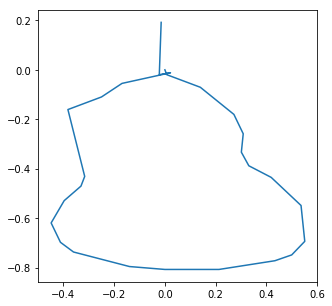

In [9]:
plot_doodle(parsed_strokes[1])

In [10]:
lengths = [len(parse_line(line)) for line in values]
min(lengths)

1

In [11]:
lengths = [len(parse_line(line)) for line in values]
max(lengths)

1048

Text(0.5, 0.98, 'Distribution of strokes lengths')

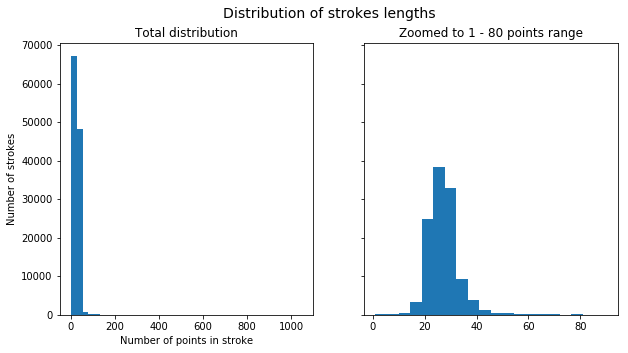

In [12]:
# plot strokes histogram
x = np.array(lengths)

fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=False, figsize=(10, 5))

axs[0].hist(x, bins=40)
axs[0].set_title('Total distribution', fontsize=12)
axs[0].set_xlabel('Number of points in stroke')
axs[0].set_ylabel('Number of strokes')

axs[1].hist(x, bins=20, range = (1, 90))
axs[1].set_title('Zoomed to 1 - 80 points range', fontsize=12)

fig.suptitle('Distribution of strokes lengths', fontsize=14)

In [13]:
# choose the length of sequences to generate
SEQ_LEN = 20

def generate_sequences(parsed_strokes, sequence_length = SEQ_LEN):
    sequences = np.zeros((1,sequence_length,3))
    targets = np.zeros((1,1,3))
    for stroke in parsed_strokes:
        if len(parsed_strokes) < sequence_length + 1:
            break;
        for i in range(0, len(stroke) - sequence_length):
            sequences = np.concatenate((sequences, stroke[i : i + sequence_length].reshape(1,sequence_length,3)), axis = 0)
            targets = np.concatenate((targets, stroke[i + sequence_length:i + sequence_length + 1].reshape(1,1,3)), axis = 0)
    return sequences[1:], targets[1:]

In [14]:
seqs, targs = generate_sequences(parsed_strokes[:3000])

In [15]:
seqs[:1]

array([[[-0.17361112,  0.16141731,  0.        ],
        [-0.08333333,  0.12204728,  0.        ],
        [-0.0625    ,  0.20078737,  0.        ],
        [ 0.        ,  0.05905515,  0.        ],
        [ 0.05555556,  0.0669291 ,  0.        ],
        [ 0.0763889 ,  0.03543305,  0.        ],
        [ 0.1875    ,  0.05118114,  0.        ],
        [ 0.31944445,  0.01968503,  0.        ],
        [ 0.24305552, -0.06299216,  0.        ],
        [ 0.05555558, -0.03149605,  0.        ],
        [ 0.0486111 , -0.07086611,  0.        ],
        [ 0.0138889 , -0.14960635,  0.        ],
        [-0.04166669, -0.12598425,  0.        ],
        [-0.06944442, -0.07480311,  0.        ],
        [-0.1736111 , -0.11811024,  0.        ],
        [-0.15277779, -0.05905512,  0.        ],
        [-0.10416666, -0.02755907,  0.        ],
        [-0.13194445, -0.01181102,  0.        ],
        [ 0.        , -0.00787401,  1.        ],
        [ 0.0625    , -0.03543307,  0.        ]]])

In [16]:
targs[:1]

array([[[ 0.0138889 , -0.07086614,  0.        ]]])

In [17]:
# convert to torch tensors
tseqs = torch.tensor(seqs).float()
ttargs = torch.tensor(targs).float()

In [18]:
# Create LSTM
class SimpleLSTM(nn.Module):
    '''
    Simple LSTM model to generate new doodles.
    '''
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(SimpleLSTM, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers)
        self.linear = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output, hidden = self.lstm(input.view(1, 1, -1), hidden)
        
        output = self.linear(output[-1].view(1, -1))
        
        output = self.softmax(output)
        return output, hidden

    # the initialization of the hidden state
    # device is cpu or cuda
    # I suggest using cuda to speedup the computation
    def initHidden(self, device):
        return (torch.zeros(self.num_layers, 1, self.hidden_size).to(device), torch.zeros(self.num_layers, 1, self.hidden_size).to(device))

# Initialize LSTM
n_hidden = 128
num_layers = 2
rnn = SimpleLSTM(3, n_hidden, 3, num_layers) # inputs and outputs of RNN are tensors representing words from the vocabulary

In [19]:
learning_rate = 0.000001 
criterion = nn.SmoothL1Loss()

In [20]:
# device to use
# don't forget to turn on GPU on kernel's settings
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [21]:
# Define training procedure
def train(sequence, target, device):
    # Move tensors to device
    hidden = rnn.initHidden(device)
    sequence = sequence.to(device)
    target = target.to(device)

    rnn.zero_grad()

    # Forward step
    for i in range(sequence.size()[0]):
        output, hidden = rnn(sequence[i], hidden)
        
    output, hidden = rnn(sequence[i], hidden)
    
    loss = criterion(output, target)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

In [22]:
# Set up the number of iterations, printing and plotting options
n_iters = 500000
print_every = 10000
plot_every = 10000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

rnn = rnn.to(device)

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

# shuffle indices
indices = np.random.permutation(tseqs.size()[0])

start = time.time()

# run training procedure
for iter in range(1, n_iters + 1):
    
    # Pick index
    index = indices[iter % tseqs.size()[0]]
    
    # Run one training step
    output, loss = train(tseqs[index], ttargs[index], device)
    current_loss += loss

    # Print iter number and loss
    if iter % print_every == 0:
        print('%d %d%% (%s) Loss: %.4f' % (iter, iter / n_iters * 100, timeSince(start), loss))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

10000 2% (4m 56s) Loss: 0.5801
20000 4% (9m 51s) Loss: 0.6173
30000 6% (14m 47s) Loss: 0.5804
40000 8% (19m 43s) Loss: 0.5408
50000 10% (24m 40s) Loss: 0.5205
60000 12% (29m 36s) Loss: 0.5905
70000 14% (34m 34s) Loss: 0.6210
80000 16% (39m 30s) Loss: 0.5782
90000 18% (44m 27s) Loss: 0.5520
100000 20% (49m 24s) Loss: 0.5434
110000 22% (54m 20s) Loss: 0.6558
120000 24% (59m 17s) Loss: 0.6037
130000 26% (64m 13s) Loss: 0.6316
140000 28% (69m 9s) Loss: 0.5545
150000 30% (74m 6s) Loss: 0.5750
160000 32% (78m 55s) Loss: 0.5665
170000 34% (83m 41s) Loss: 0.9371
180000 36% (88m 20s) Loss: 0.5625
190000 38% (92m 52s) Loss: 0.6307
200000 40% (97m 26s) Loss: 0.6118
210000 42% (101m 59s) Loss: 0.6381
220000 44% (106m 35s) Loss: 0.6185
230000 46% (111m 7s) Loss: 0.5895
240000 48% (115m 43s) Loss: 0.8750
250000 50% (120m 23s) Loss: 0.6237
260000 52% (125m 13s) Loss: 0.6166
270000 54% (130m 2s) Loss: 0.5676
280000 56% (134m 42s) Loss: 0.6157
290000 57% (139m 17s) Loss: 0.5699
300000 60% (143m 51s) Lo

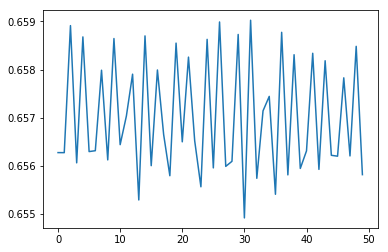

In [23]:
# plot training loss
plt.figure()
plt.plot(all_losses)

In [24]:
# Sample title from the trained model
def sample():   
    max_strokes = 30
    
    # Initialize input step and hidden state
    input = torch.zeros(1, 3)
    hidden = (torch.zeros(num_layers, 1, n_hidden).to(device), torch.zeros(num_layers, 1, n_hidden).to(device))
    
    i = 0
    doodle = torch.zeros(1, 3).to(device)
    output = torch.zeros(1, 3).to(device)
    # Sample words from the model
    while output[0,2] != 1.0 and i < max_strokes:
          
        input = input.to(device)
        output, next_hidden = rnn(input, hidden)
        
        y = output.clone()
        y = y.to(device)
        doodle = torch.cat((doodle, output), dim = 0)
         
        hidden = next_hidden
        input = output
        i = i+1
        
    return doodle[1:]

In [25]:
doodle = sample()

In [26]:
doodle

tensor([[-1.1641, -1.0757, -1.0592],
        [-1.1558, -1.0777, -1.0647],
        [-1.1493, -1.0799, -1.0685],
        [-1.1448, -1.0818, -1.0708],
        [-1.1418, -1.0833, -1.0721],
        [-1.1399, -1.0844, -1.0728],
        [-1.1388, -1.0851, -1.0731],
        [-1.1382, -1.0856, -1.0732],
        [-1.1378, -1.0859, -1.0733],
        [-1.1375, -1.0861, -1.0733],
        [-1.1374, -1.0863, -1.0733],
        [-1.1373, -1.0864, -1.0733],
        [-1.1373, -1.0864, -1.0733],
        [-1.1372, -1.0865, -1.0733],
        [-1.1372, -1.0865, -1.0733],
        [-1.1372, -1.0865, -1.0733],
        [-1.1372, -1.0865, -1.0733],
        [-1.1372, -1.0865, -1.0733],
        [-1.1372, -1.0865, -1.0733],
        [-1.1372, -1.0865, -1.0733],
        [-1.1372, -1.0865, -1.0733],
        [-1.1372, -1.0865, -1.0733],
        [-1.1372, -1.0865, -1.0733],
        [-1.1372, -1.0865, -1.0733],
        [-1.1372, -1.0865, -1.0733],
        [-1.1372, -1.0865, -1.0733],
        [-1.1372, -1.0865, -1.0733],
 

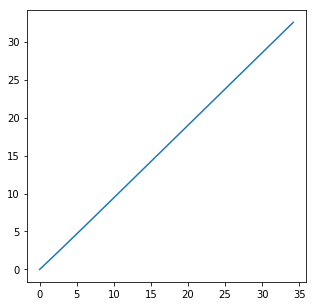

In [27]:
plot_doodle(doodle)

## References:
1. [PyTorch loss functions](https://medium.com/udacity-pytorch-challengers/a-brief-overview-of-loss-functions-in-pytorch-c0ddb78068f7) - overview of loss functions in PyTorch.